# Milestone 4

In [1]:
# Imports
import zipfile
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

## Table of Contents

1. Problem Statement and Research Question
2. Explore and Visualize Data
3. Baseline Model
4. Results Interpretation 
5. Final Model Pipeline



## 1. Problem Statement and Research Question


### 1a. Background Information

Voter turnout reflects the health of a democratic system, measuring the participation of its members in the electoral process.  However, it is widely documented that voter turnout varies significantly across demographic groups such as age, race, education, and income. Research finds that nonvoters are more likely to be younger, identify as non-White, have low education, and come from low income households ([Pew Research Group, 2023](https://www.pewresearch.org/politics/2023/07/12/voter-turnout-2018-2022/)). Further understanding these patterns is crucial for identifying barriers to participation and designing policies to improve turnout ([MIT, 2021](https://electionlab.mit.edu/research/voter-turnout)).

This project explores the predictive power of voter characteristics on voter turnout for the 2020 presidential election in the state of Massachusetts. By leveraging Census Block Group data, this study aims to uncover localized patterns that aggregate county or state-level studies ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)) or individual-level studies ([Kim, 2024](https://link.springer.com/article/10.1007/s11109-022-09816-z#Sec14)) may overlook.

### 1b. Main Question

How do different voter characteristics influence voter turnout in Massachusetts?

## 2. Explore and Visualize Data

### 2a. Information on the Data

To answer this question, we use voter turnout data at the Census Block level sourced from L2 Data and Redistricting Data Hub.

We applied several processing steps which included:
1. Dropped observations without Census Block IDs that were instead aggregated to the County level (73,811 or ~1.60% of total voters). Disaggregating these observations necessitated the assumption that demographic characteristics are uniformly distributed across the County, which is false.
2. Aggregated the Census Block data to the Census Block Group level to reduce the high variance of registered voter counts in each observation.
3. Converted most demographic predictors from counts of voters to proportion of voters. We did this to account for differences in the number of voters that lived in each Census Block Group (a Census Block Group in a city will likely have a higher voter count than a Census Block Group in rural Massachusetts).

Our response variable is the proportion of registered voters that voted in the 2020 presidential election, denoted as `2020_turnout_pct`.

Our predictors include the total number of voters registered, mean household income, and the proportion of people with specific characteristics such as age; ethnicity; party affiliation; and language.

In [2]:
# Read in the initial data
with zipfile.ZipFile("../data/MA_l2_2022stats_2020block.zip") as z:
        with z.open("MA_l2_2022stats_2020block.csv") as f:
            init_df = pd.read_csv(f, low_memory=False).set_index("geoid20")

In [3]:
# Read in the final data
voter_gdf = gpd.read_file("../data/block_groups.geojson")

In [4]:
# Group the variables together
registered = ["total_reg"]
income = ["mean_hh_income"]
age = ["age_18_19", "age_20_24", "age_25_29", "age_30_34", "age_35_44", 
       "age_45_54", "age_55_64", "age_65_74", "age_75_84", "age_85over"]
gender = [ "gender_m", "gender_f", "gender_unknown"] 
party = ["party_npp", "party_dem", "party_rep", "party_lib", "party_grn", 
         "party_con", "party_ain", "party_scl", "party_oth"]
ethnicity1 = ["eth1_eur", "eth1_hisp", "eth1_aa",
                "eth1_esa", "eth1_oth", "eth1_unk"]
languages = ["lang_english", "lang_spanish", "lang_portuguese",
             "lang_chinese", "lang_italian", "lang_vietnamese", 
             "lang_other", "lang_unknown"]
predictors = [*registered, *income, *age, *gender, *party, *ethnicity1, *languages]

In [5]:
# Define X and y 
X = voter_gdf.copy()

### 2b. Data Visualization

"Conduct exploratory data analysis to understand the underlying patterns and relationships in the data. Visualizations can be helpful in identifying trends and outliers. Make sure that the EDA you present explains the feature engineering choices you made. Moreover, when we read through your notebook, we expect to understand why you choose the particular baseline model and why you engineer your features the way you did. This section would be a great way to provide your reasoning."

In [6]:
# Define plotting functions

# Plots the distribution of a continuous variable, annotating median and 5th / 95th percentile
def plotdist(data, title, column, xlabel, ylabel, annotation_format, annotation_height):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8,6))

    # KDE plot
    sns.kdeplot(data, x=column, linewidth=3, alpha=0.75, ax=ax)

    # Calculate statistics
    median = data[column].median()
    p5 = np.percentile(data[column], 5)
    p95 = np.percentile(data[column], 95)

    # Add vertical lines for statistics
    plt.axvline(x=median, linestyle="--", color="r", linewidth=2, label="Median")
    plt.axvline(x=p5, linestyle=":", color="k", linewidth=2, label="5th percentile")
    plt.axvline(x=p95, linestyle=":", color="k", linewidth=2, label="95th percentile")

    # Annotate statistics on the plot
    y_min, y_max = ax.get_ylim()
    plt.text(median, annotation_height[1] * y_max, annotation_format.format(median), color="r", bbox={"edgecolor":"r", "facecolor":"white", "alpha":0.9}, ha="center")
    plt.text(p5, annotation_height[0] * y_max, annotation_format.format(p5), color="k", bbox={"edgecolor":"k", "facecolor":"white", "alpha":0.9}, ha="center")
    plt.text(p95, annotation_height[2] * y_max, annotation_format.format(p95), color="k", bbox={"edgecolor":"k", "facecolor":"white", "alpha":0.9}, ha="center")

    # Customize axes
    print()
    plt.xticks(ax.get_xticks(), [annotation_format.format(x) for x in ax.get_xticks()])
    plt.xlim(data[column].min(), data[column].max())
    
    # Add the custom legend to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

# Creates a scatterplot of two continuous variables
def plotscatter(data, title, x_column, y_column, xlabel, ylabel, label_format):
    fig,ax = plt.subplots(figsize = (8,6))

    # Plot the data
    sns.scatterplot(voter_gdf, x=x_column, y=y_column, alpha=0.3)

    # Add the custom legend to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks=ax.get_xticks(), labels=[label_format.format(x) for x in ax.get_xticks()])
    plt.xlim(0, max(ax.get_xticks()))
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.show()

# Plots voter distribution by category via kernel density
def plotKDE(data, title, vars, labels, colors, xlabel):
    fig,ax = plt.subplots(figsize = (8,6))
    legend_elements =[]
    for i in range(len(vars)):
        sns.kdeplot(data, x=vars[i], y='2020_turnout_pct', ax=ax,
                    color=colors[i],
                        alpha=0.3,
                        label=labels[i]
                    )
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=4, label=labels[i]))

    # Add the custom legend to the plot
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.xlabel(f'Proportion of {xlabel} Relative to Total Registered Voting Population')
    plt.ylabel('Voter Turnout')
    plt.grid(alpha=0.3)
    plt.show()

#### 2b. i. Distribution of Voter Turnout

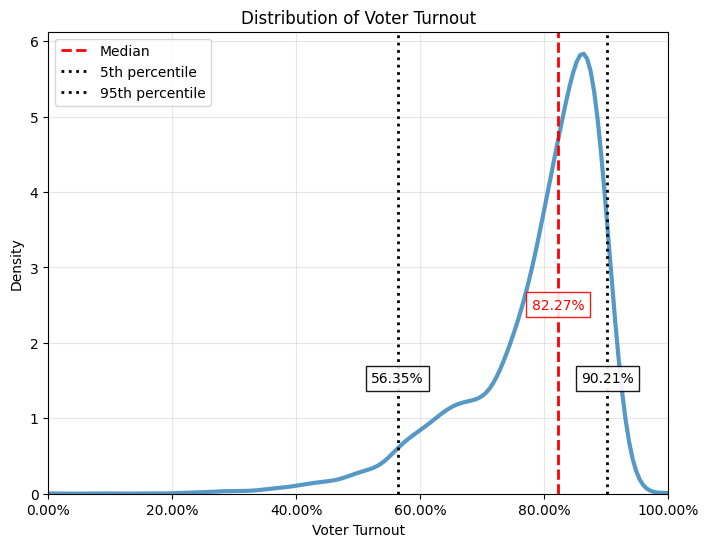

In [7]:
plotdist(X, "Distribution of Voter Turnout", 
         "2020_turnout_pct", "Voter Turnout", "Density",
         "{:.2%}", [0.24,0.4,0.24])

In the plot below, we can see that the distribution of the number of voters registered looks approximately normally distributed, which is why we use StandardScaler to scale for our linear regression model.

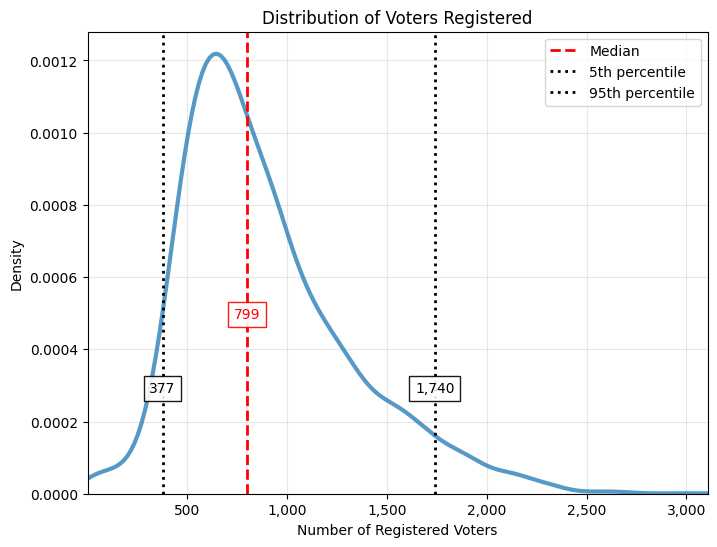

In [8]:
plotdist(X, "Distribution of Voters Registered", 
         "total_reg", "Number of Registered Voters", "Density",
         "{:,.0f}", [0.22,0.38,0.22])

#### 2b. ii. Voter Turnout by Income

Similar to the number of registered voters, in plotting the distribution of mean household income, we can see that it is approximately normally distributed. 

For this reason, we chose to use StandardScaler when using this predictor in the linear regression model.

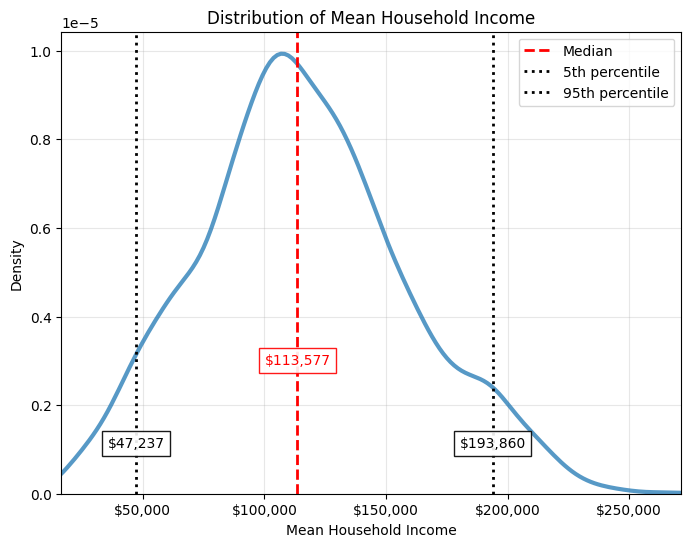

In [9]:
plotdist(X, "Distribution of Mean Household Income", 
         "mean_hh_income", "Mean Household Income", "Density",
         "${:,.0f}", [0.1,0.28,0.1])

We also see a negative relationship between voter turnout and mean household income where block groups with higher/lower income have higher/lower voter turnout on average.

Based on the scatterplot below, in our baseline linear regression model, we expect to see a negative coefficient for `mean_hh_income`.

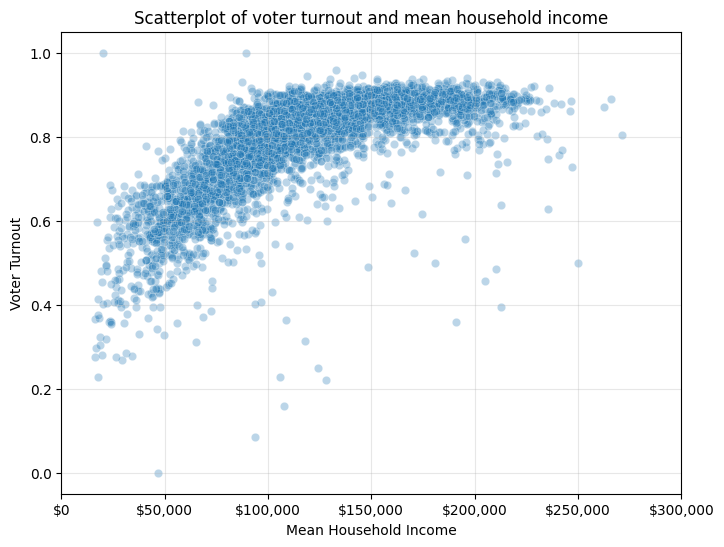

In [10]:
plotscatter(X, "Scatterplot of voter turnout and mean household income", 
            "mean_hh_income", "2020_turnout_pct", 
            "Mean Household Income", "Voter Turnout", "${:,.0f}")

#### 2b. iii. Voter Turnout by Party

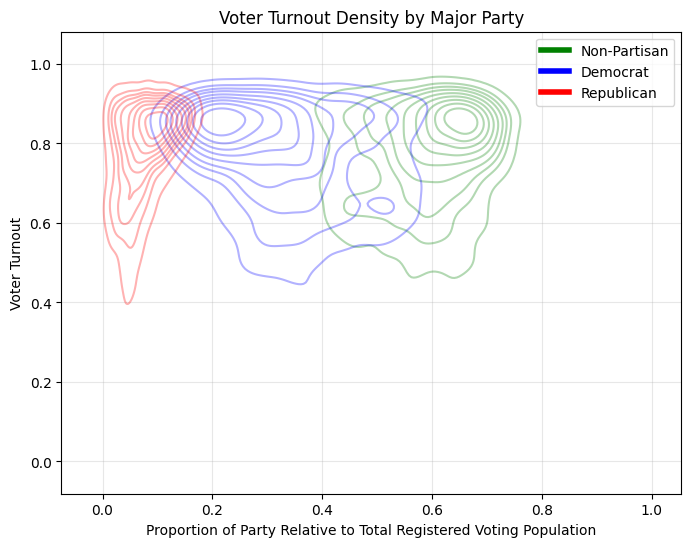

In [11]:
plotKDE(X, 'Voter Turnout Density by Major Party',
        ['party_npp', 'party_dem', 'party_rep'],
        ['Non-Partisan', 'Democrat', 'Republican'],
        ['green','blue','red'],
        'Party')

Of the parties, Non-Partisan, Democrat, and Republican were the most prevalent, with NP actually representing the majority of registered voters in all counties. Republicans make up the minority of registered voters which is why they are gathered on the far left of the plot; the opposite is true for NP. The densest areas of the KDE plot differ greatly on the x-axis but are actually similiar in terms of voter turnout. 

#### 2b. iv. Voter Turnout by Ethnicity

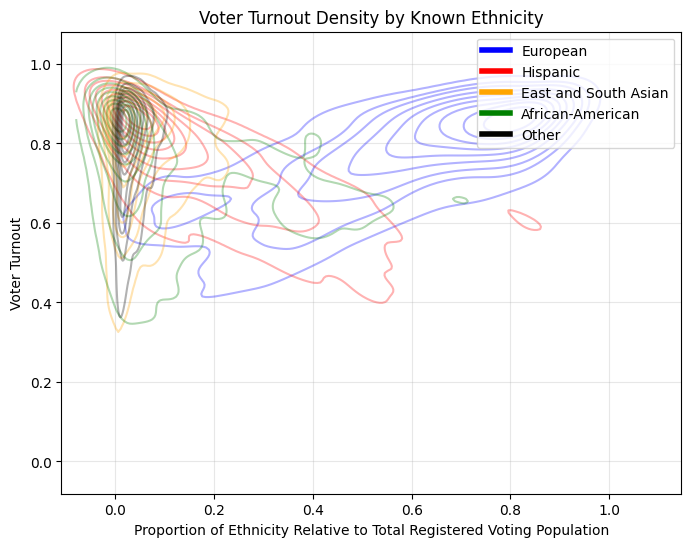

In [12]:
plotKDE(X, 'Voter Turnout Density by Known Ethnicity',
        ['eth1_eur','eth1_hisp', 'eth1_esa', 'eth1_aa','eth1_oth'],
        ['European', 'Hispanic',  'East and South Asian', 'African-American',  'Other'],
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Ethnicity')

Here we can observe the following trends
1. As the density of European voters increases, the voter turnout tends to increase
2. As the density of Hispanic voters increases, the voter turnout tends to decrease
3. There is a similar negative correlation amongst African American voters as hispanic voters; however it is less pronounced than the trend found with hispanic voters 
4. "Other" and "East and South Asian" represent very little of the registered population. 

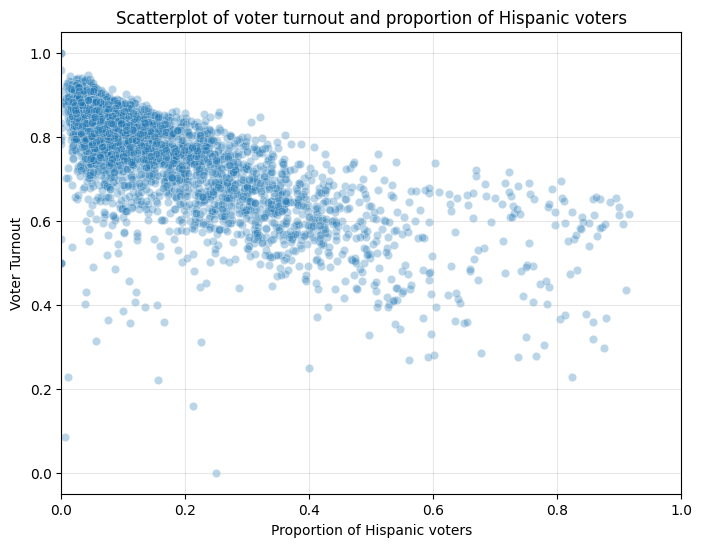

In [13]:
plotscatter(X, "Scatterplot of voter turnout and proportion of Hispanic voters", 
            "eth1_hisp", "2020_turnout_pct", 
            "Proportion of Hispanic voters", "Voter Turnout", "{:.1f}")

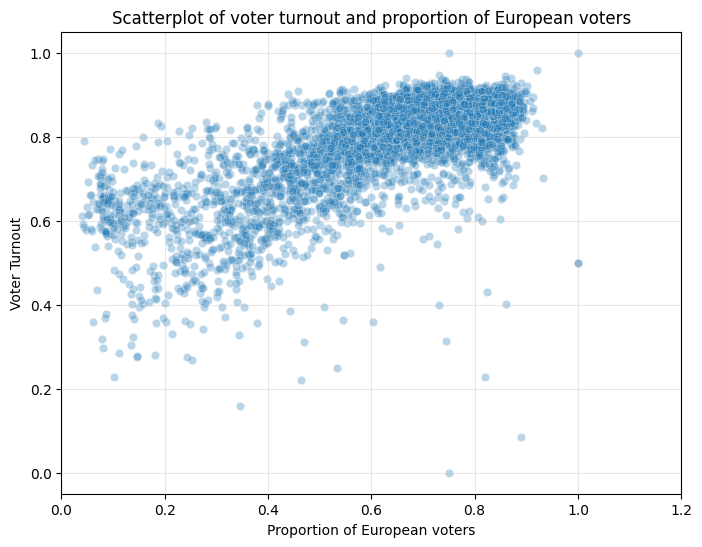

In [14]:
plotscatter(X, "Scatterplot of voter turnout and proportion of European voters", 
            "eth1_eur", "2020_turnout_pct", 
            "Proportion of European voters", "Voter Turnout", "{:.1f}")

#### 2b. v. Voter Turnout by Age

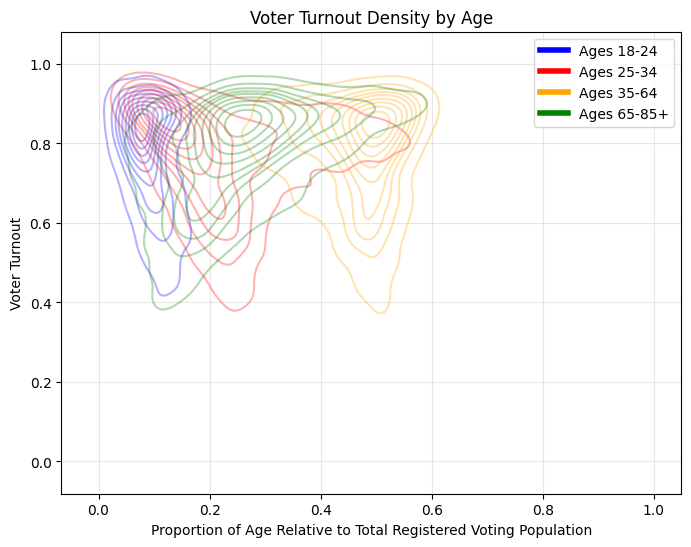

In [15]:
# Group together age bins for better visualization
X["age_18_24"] = X["age_18_19"]+ X["age_20_24"]
X["age_25_34"] = X["age_25_29"]+ X["age_30_34"]
X["age_35_64"] = X["age_35_44"]+ X["age_45_54"]+ X["age_55_64"]
X["age_65_85over"] = X["age_65_74"]+ X["age_75_84"] + X["age_85over"]

plotKDE(X, 'Voter Turnout Density by Age', 
        ['age_18_24','age_25_34', 'age_35_64', 'age_65_85over'], 
        ['Ages 18-24', 'Ages 25-34',  'Ages 35-64', 'Ages 65-85+'] ,  
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Age')

Here we can observe the following trends
1. 35-64 grouping is over-represented in the population of registered voters
2. 18-24 alternatively are under-represented in teh population of registered voters
3. There appears to be a positive relationship with voters 65+ and voter turnout

#### 2b. vi. Voter Turnout by Language

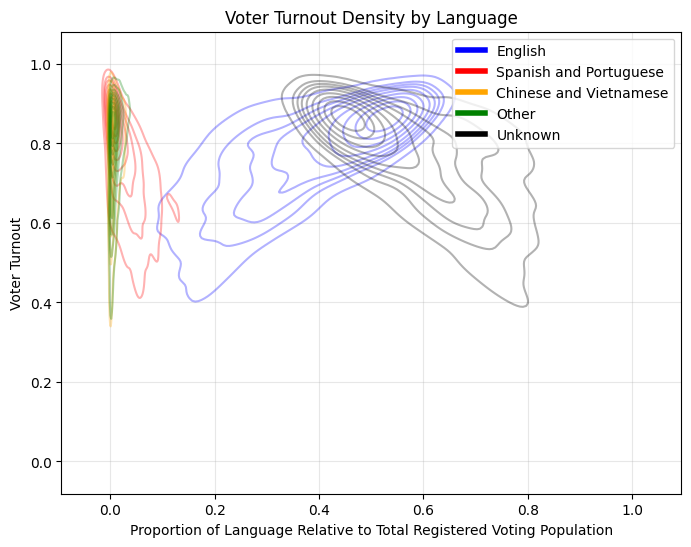

In [16]:
# Group together spanish+portuguese and vietnamese+chinese for better visualization
X["lang_spanish_portuguese"] =X["lang_spanish"]+X["lang_portuguese"]
X["lang_chinese_vietnamese"] = X["lang_chinese"] + X["lang_vietnamese"]
plotKDE(X, 'Voter Turnout Density by Language',
        ['lang_english','lang_spanish_portuguese','lang_chinese_vietnamese','lang_other', 'lang_unknown'],
        ['English', 'Spanish and Portuguese',  'Chinese and Vietnamese', 'Other', 'Unknown'], 
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Language')

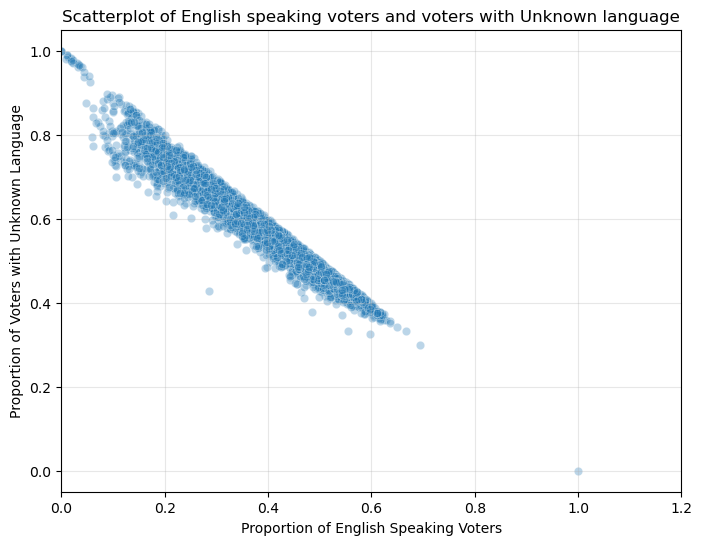

In [171]:
plotscatter(X, "Scatterplot of English speaking voters and voters with Unknown language",
            "lang_english","lang_unknown",
            "Proportion of English Speaking Voters", "Proportion of Voters with Unknown Language", "{:.1f}")

Here we can observe the following trends
1. "English" and "Unknown" dominate make up the majority of the labels for language
2. there is a clear positive correlation between more english dense blocks and higher voter turnout
3. there is a clear negative correlation between more "unknown" dense blocks and lower voter turnout
4. There is a negative correlation between spanish and portugese speakers and voter turnout
5. "Unknown" can be classified as Missing at Random (MAR); we know that English speaking dense blocks tend to have higher voter turnout. Therefore, it is very likely that "unknown" is overrepresented by non-english speakers. 
6. "English" and "Unknown" are almost perfectly negatively correlated, indicating that L2 Data was unable to obtain the specific Language spoken for non-English speaking voters.

## 3. Baseline Model

As our baseline model, we utilized all 38 predictors which comprised of Census Block Group data on the number of voters registered, mean household income, and proportions of age; gender; party affiliation; ethnicity; and language spoken.

Our choice in using demographic proportions instead of counts is in line with existing research on voter turnout and demographics ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)).

We scaled mean household income and the number of voters registered in each Census Block Group using StandardScaler (due to these variables being approximately normally distributed).

We used 80% of the Census Block Groups to train and the remainder 20% for the test set.

Finally, we report the train and test MSE and R-squared scores below, which we will use to compare our future models.

In [227]:
# reduce to just predictors
X = voter_gdf[predictors].copy()
# scale non ratio values
X[['total_reg','mean_hh_income']] = StandardScaler().fit_transform(X=X[['total_reg','mean_hh_income']])
y = voter_gdf['2020_turnout_pct']

# test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# fit model
linreg = LinearRegression().fit(X_train,y_train)

# Report accuracy
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

	Train		Test
MSE	0.00215		0.00246
R2	0.82778		0.81028


We think that an R-squared score of 0.81028 is decent for a model that has minimal feature engineering.

But to answer the central question "how does demographics affect voter turnout?", we need to examine the importance of each predictor in the model.

## 4. Interpret the Results

#### 4a. Feature Importance

After training the linear regression model, we plot the coefficients of the predictors to evaluate their importance on voter turnout.

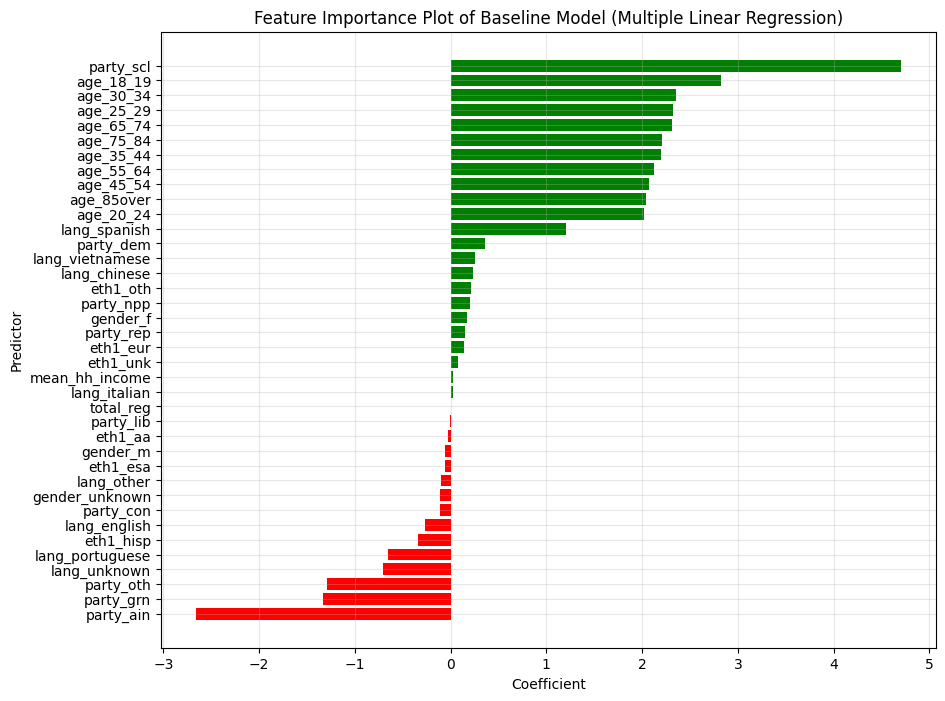

In [19]:
def gatherAndPlotFeatureCoef(model, label):
    # gather pred/coeff results
    preds = []
    coefs = []
    for pred, coef in zip(X.columns,model.coef_):
        preds.append(pred)
        coefs.append(coef)
    coef_df = pd.DataFrame({'Predictor': preds, 'Coefficient':coefs})

    # Visualize coefficients
    # Sort by 'Coefficient' to improve visualization
    coef_df = coef_df.sort_values('Coefficient', ascending=True).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(10, 8))
    colors = coef_df['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red')
    plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color=colors)

    # Add titles and labels
    plt.xlabel('Coefficient')
    plt.ylabel('Predictor')
    plt.title('Feature Importance Plot of Baseline Model '+label)

    # Display plot
    plt.grid(alpha=0.3)
    plt.show()
    return coef_df

coef_df_lr = gatherAndPlotFeatureCoef(linreg,'(Multiple Linear Regression)')

Our Multiple Linear Regression model indicated that the following features has a positive association with voter turnout (ordred from most important/highest beta to least important/lowest beta). This means that having higher proportions of these populations are projected to increase voter turnout.
1. socialist party
2. any age group
3. spanish language
4. democratic party
5. Vietnamese language
6. Chinese language
7. "other" ethnicity
8. non-partisan registration
9. female gender/sex
10. republican party
11. European ethnicity 
12. "unknown" ethnicity
13. mean income


It identified the following features as having a negative association with voter turnout (ordered from most to least important). This means that having higher proportions of these populations are projected to decrease voter turnout.
1. American Ind. Party
2. Green party
3. "other" party
4. "unknown" language label
5. Portuguese language
6. Hispanic ethnicity 
7. English language
8. Conservative party
9. unknown gender
10. "other" language
11. East and South Asian ethnicity
12. male gender/sex
13. African American ethnicity 
14. Libertarian party

Things that do make sense
1. Democratic party registration as democrats did win every county
2. female sex/gender. Women make up a slight majority of registered voters in every county. 
3. European ethnicity having a positive association is consistent with our EDA
4. Hispanic ethnicity having a negative assocation is consistent with our EDA

Things that don't make sense
1. all ages groups having a positive association. Existing research on the subject posits that younger voters tend to have lower voter turnout, so it's concerning that 18-19 are leading in the langauge categories. 
2. Spanish language - we observed in our EDA a clear negative correlation between spanish speaking and voter turnout.
3. mean income having a low value is inconsistent with our EDA, we would expect to see a coefficient with a higher magnitude associated with this predictor.

We believe these results that are inconsistent with the literature and our EDA are due to multicollinearity between several predictors. For example, "English" and "Unknown Language" are almost perfectly negatively correlated. This multicollinearity may have influenced the beta coefficients in the baseline model.


### 4b. LASSO Cross Validation

To tackle the issue of multicollinearity, our team employed cross validation using a LASSO regularized linear regression to identify features that may be less relevant to voter turnout.

We plot the predictors and their associated beta coefficient below.

In [20]:
# use CV to select best alpha/lambda value lasso model
lasso_alphas = np.logspace(-4, 0, 1000)
lasso = LassoCV(alphas=lasso_alphas, cv=10, max_iter=1000).fit(X_train, y_train)
lasso_a = lasso.alpha_
print(f'LASSO with alpha={lasso_a:.5f}: {lasso.score(X_test, y_test):.3}')

# fit with CV alpha
cross_lasso_model = Lasso(alpha=lasso_a).fit(X_train, y_train)

# Report accuracy
y_pred_train = cross_lasso_model.predict(X_train)
y_pred_test = cross_lasso_model.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

LASSO with alpha=0.00010: 0.798
	Train		Test
MSE	0.00246		0.00261
R2	0.80265		0.79828


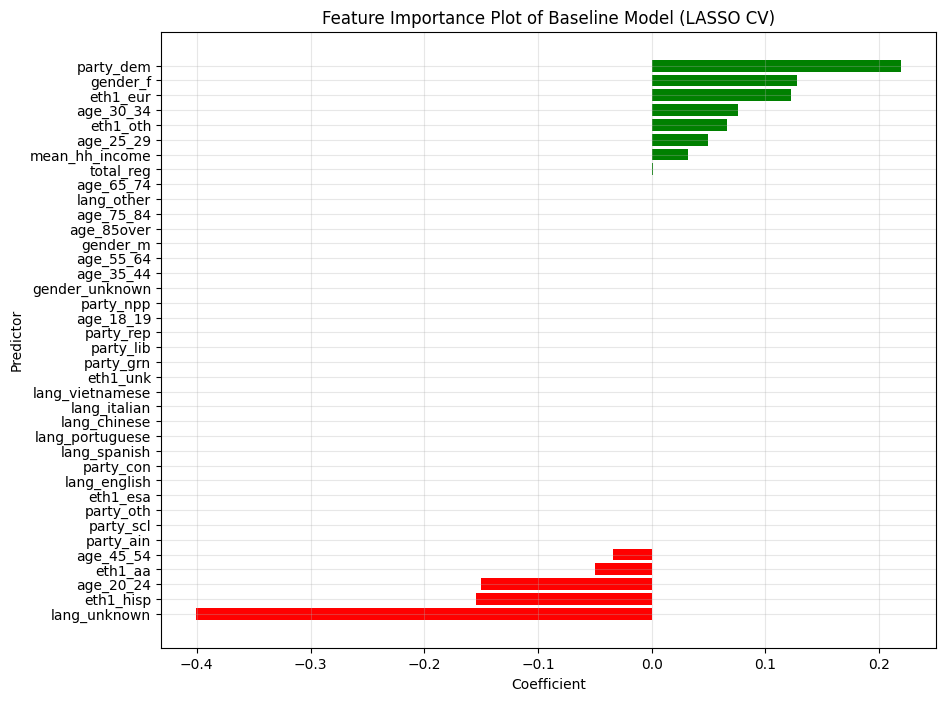

In [21]:
coef_df_lasso = gatherAndPlotFeatureCoef(cross_lasso_model,'(LASSO CV)')

Based on the plot above of the LASSO regularized regression, the model identified 12 features that are relevant (beta coefficients not equal to 0).

Features with positive association with higher voter turnout
1. Democratic Party registration
2. female gender
3. European ethnicity
4. Age group 30-34
5. age group 25-29
6. higher mean income
7. total registered voters

Features with negative association with higher voter turnout
1. Unknown language label
2. Hispanic ethnicity 
3. Age group 20-24
4. African American ethnicity 
5. Age grop 45-54

These 12 features identified as important by the LASSO model make more sense in the context of our EDA and the existing literature on voter turnout and demographics.

### 4c. Permutation Importance

To confirm our LASSO model's results, we also use permutation importance to identify the most relevant features in predicting voter turnout. 

Specifically, permutation importance tells us how much the model's performance decreases when the values of a given feature are randomly shuffled. 

In [22]:
def permImportPlot(label, model, X_train, y_train):
    results = permutation_importance(model, X_train, y_train, n_repeats=5)

    # Extract importance scores for each feature
    coefs = []
    for pred, coef in zip(X_train.columns,model.coef_):
        coefs.append(coef)

    perm_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance_mean': results.importances_mean,
        'importance_std': results.importances_std, 
        'betas':coefs
    }).sort_values('importance_mean', ascending=False)

    perm_imp = perm_imp[perm_imp['importance_mean'] > 0]


    F = list(perm_imp['feature'])
    I = list(perm_imp['importance_mean'])
    E = list(perm_imp['importance_std'])
    B = list(perm_imp['betas'])
    F.reverse()
    I.reverse()
    E.reverse()
    B.reverse()
    colors = ['red' if b < 0 else 'green' for b in B]



    # Plot top 10 features with error bars
    plt.figure(figsize=(10, 8))


    plt.barh(range(len(perm_imp)), I, xerr=E, capsize=5, color=colors)
    plt.yticks(range(len(perm_imp)), F)
    plt.title('Permutation Importance of Features for '+label+" model")
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()


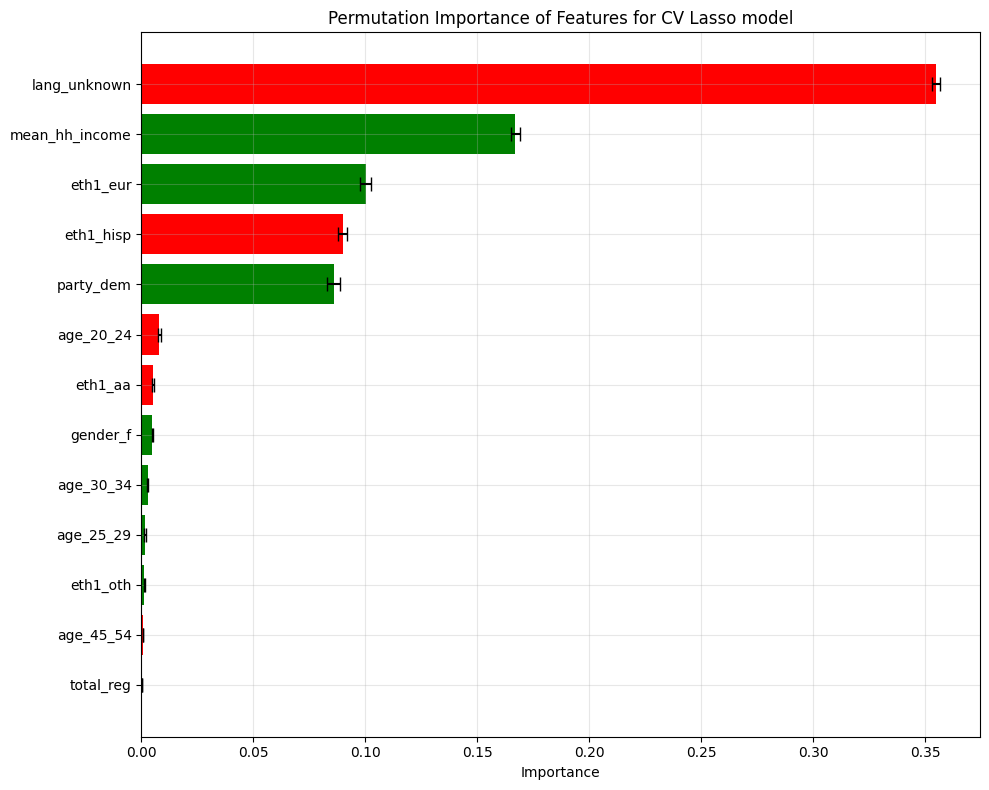

In [23]:
permImportPlot("CV Lasso", cross_lasso_model, X_train, y_train)

From the plot above, we can tell that unknown language labeling, mean income, and European ethnicity are strongly correlated with the target variable of voter turnout (negative and positive impact) since disrupting their values results in a large drop in model performance

Most Important Positive Beta Features
1. Mean Income
2. European Ethnicity 
3. Democratic Party Registration

Most important Negative Beta Features
1. Unknown language label 
2. Histpanic idenity 

This somewhat confirms the results of the LASSO model, with unknown language labeling, European ethnicity, and Hispanic ethnicity marked as important in both permutation importance and LASSO.

On the other hand, female voters, voters aged 30-34, and voters aged 20-24 seemed more important in the LASSO model results than the permutation importance results. 

## 5. Final Model Pipeline

### 5a. Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Reduce to just predictors, no scaling since decision trees are not sensitive to scale
X = voter_gdf[predictors].copy()
# Isolate response variable
y = voter_gdf['2020_turnout_pct']

# Same train and test split as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# Fit the random forest without tuning hyperparameters
rf =  RandomForestRegressor(n_estimators=50, max_depth=20, max_features="sqrt", random_state=0)
rf.fit(X_train, y_train)

# Report scores
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

	Train		Test
MSE	0.00029		0.00185
R2	0.97698		0.85757
